In [1]:
first_time_importing_torch = True

In [20]:
import time
# NOTE: Importing torch the first time will always take a long time!
if first_time_importing_torch:
    print(f"Importing torch ...")
    import_torch_start_time = time.time() 
import torch
if first_time_importing_torch:
    import_torch_end_time = time.time()
    print(f"Importing torch took {import_torch_end_time - import_torch_start_time} seconds")
    first_time_importing_torch = False

import torchvision.transforms as transforms  # Transform PIL images to tensors 


import os
from tqdm import tqdm
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt



In [3]:
CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"

In [4]:
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images_chest_xray(data_path: str, ids: list) -> list:
    files = os.listdir(data_path)
    jpeg_files = [f for f in files if f.endswith(".jpeg")]

    images = []
    for id in tqdm(ids):
        if id >= len(jpeg_files): continue
        # print(f"Loading image {id} from {data_path}")
        image = Image.open(os.path.join(data_path, jpeg_files[id]))
        images.append(image)
    
    return images

100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


(1857, 1317)


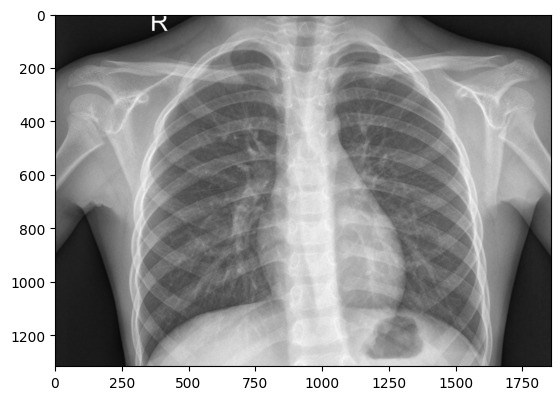

In [5]:
def test_load_images_chest_xray(stage="test", label="NORMAL"):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/{stage}/{label}", [0]):
        print(img.size)
        plt.imshow(img, cmap='gray')
    plt.show();

test_load_images_chest_xray()

In [17]:
def get_variable_noise(sigma_min, sigma_max):
    # return sigma_min + torch.rand(1) * (sigma_max - sigma_min)
    return sigma_min + np.random.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: np.ndarray, sigma) -> np.ndarray:
    std = np.std(xf)
    mu = np.mean(xf)

    x_centred = (xf  - mu) / std

    # x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)
    x_centred += sigma * np.random.randn(*xf.shape)

    xnoise = std * x_centred + mu

    del std, mu, x_centred

    return xnoise


def tensor_2d_to_image(tensor_2d: torch.tensor) -> Image:
    tensor_2d_np = tensor_2d.to("cpu").detach().numpy()
    tensor_2d_np_int = (tensor_2d_np * 255.0).clip(0, 255.0).astype(np.uint8)
    image = Image.fromarray(tensor_2d_np_int)
    return image


def get_noisy_image(rgb: Image, sigma) -> Image:
    grayscale = rgb.convert("L")
    
    im_np = np.array(grayscale) / 255.0
    # im_2d = torch.tensor(im_np, dtype=torch.float32) / 255.0
    # noisy_2d = add_noise(im_2d, sigma=sigma)
    # noisy_im = tensor_2d_to_image(noisy_2d)

    noisy_im_np = (add_noise(im_np, sigma=sigma) * 255.0).clip(0, 255.0).astype(np.uint8)
    noisy_im = Image.fromarray(noisy_im_np)
    return noisy_im

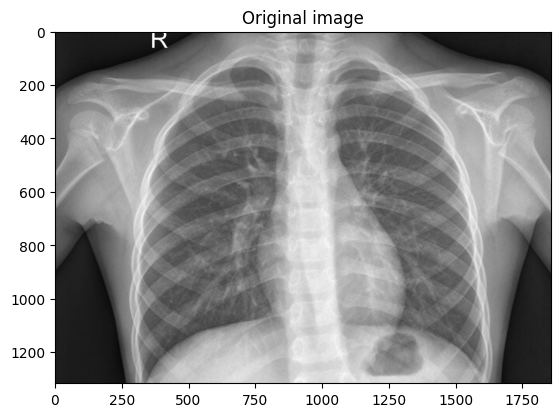

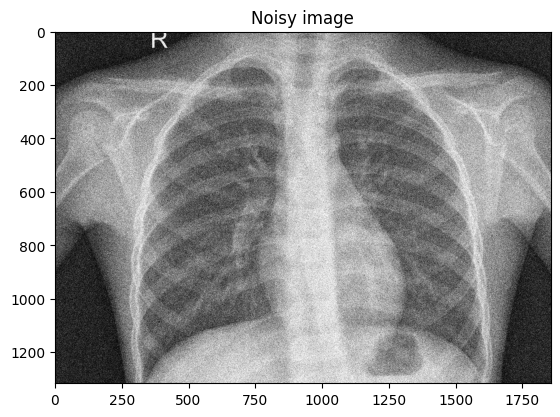

In [16]:
def test_gen_noisy_images():
    # img = load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/test/NORMAL", [0])[0]
    img = Image.open("../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
    plt.imshow(img, cmap='gray')
    plt.title("Original image")
    plt.show();
    
    noisy_img = get_noisy_image(img, 0.9)
    plt.imshow(noisy_img, cmap='gray')
    plt.title("Noisy image")
    plt.show();

test_gen_noisy_images()

In [18]:
def gen_noisy_images_for_sigma(data_path, subfolder, label, files, output_path, sigma, overwrite=False):
    for file in tqdm(files):
        output_file = f"{output_path}/{file}"
        if not overwrite and os.path.exists(output_file):
            continue

        img = Image.open(f"{data_path}/{subfolder}/{label}/{file}")
        noisy_img = get_noisy_image(img, sigma)
        noisy_img.save(output_file)


def gen_noisy_images(subfolders, labels, sigmas, overwrite=False):
    chest_xray_data_path = f"../data/chest_xray"
    for subfolder in subfolders:
        for label in labels:
            files = os.listdir(f"{chest_xray_data_path}/{subfolder}/{label}")
            for sigma in sigmas:
                sigma = round(sigma, 1)
                print(f"Generating noisy images for {subfolder}/{label} with sigma={sigma} (overwrite={overwrite})")
                sigma_str = str(sigma).replace(".", "_")
                output_path = f"{chest_xray_data_path}/{subfolder}/{label}_noisy_{sigma_str}"
                os.makedirs(output_path, exist_ok=True)
                gen_noisy_images_for_sigma(chest_xray_data_path, subfolder, label, files, output_path, sigma, overwrite=overwrite)

In [19]:
gen_noisy_images(["val"], ["PNEUMONIA"], [0.1], overwrite=False)


Generating noisy images for train/PNEUMONIA with sigma=2.0 (overwrite=False)


100%|██████████| 3875/3875 [02:48<00:00, 22.96it/s]
